# Desarrollo de la información

## Fase 2: Análisis de la información

Utilizar los datos almacenados en el archivo “Productividad.xlsx” para generar un análisis con el cual logre identificar cual es el cargo más conveniente contratar enfocado en incrementar la productividad.

+ Los datos son llamados directamente desde el repositorio GitHub

In [1]:
# LIBRERIAS
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Creación de las rutas, funciones para carga de los datos y cración de los DataFrames

In [2]:
# ---- PATHS
productividad_path = "https://raw.githubusercontent.com/julaux/Data-Analysis/main/Tuya/Input/Productividad.xlsx"
segmentacion_catt_path = "https://raw.githubusercontent.com/julaux/Data-Analysis/main/Tuya/Input/Segmentacion_CATT.xlsx"


# --- CARGA DE DATOS
# PRODUCTIVIDAD
def read_productividad(path: str) -> pd.DataFrame:
    """
    Carga la información de productividad

    Args:
        - path (str): Ruta del archivi de productividad
    Returns:   
        - df (pd.DataFrame): DataFrame con la información de productividad
    """
    df = pd.read_excel(path, parse_dates=['fecha_dia', 'ult_fecha_ingreso'])
    df['fecha_dia'] = pd.to_datetime(df['fecha_dia'], format='%Y-%m-%d', errors='coerce')
    df['ult_fecha_ingreso'] = pd.to_datetime(df['ult_fecha_ingreso'], format='%d/%m/%Y', errors='coerce')

    df['fecha_dia'] = df['fecha_dia'].dt.date
    df['ult_fecha_ingreso'] = df['ult_fecha_ingreso'].dt.date


    return df

# SEGMENTACIÓN
def read_segmentacion_catt(path):
    """
    Carga la información de la segmentación CATT

    Args:
        - path (str): Ruta del archivo de segmentación  
    
    Returns:
        - df (pd.DataFrame): DataFrame con la información de segmentación
    """
    df = pd.read_excel(path)

    return df


# --- CARGA DE DATOS
# PRODUCTIVIDAD
df_productividad = read_productividad(productividad_path)

# SEGMENTACION
df_segmentacion = read_segmentacion_catt(segmentacion_catt_path)

### 2.1 Análisis EDA de la información

Tipo de datos y visualización de la tabla *productividad* (df_productividad)

In [3]:
df_productividad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34915 entries, 0 to 34914
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   dia_sem            34915 non-null  object
 1   fecha_dia          34915 non-null  object
 2   mes                34915 non-null  object
 3   neg                34915 non-null  object
 4   region             34915 non-null  object
 5   canal              34915 non-null  int64 
 6   cedula             34915 non-null  object
 7   cargobase          34915 non-null  object
 8   ult_fecha_ingreso  34915 non-null  object
 9   antiguedad         34915 non-null  object
 10  capt_tot           34915 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 2.9+ MB


* Se cuenta con un dataset de 34915 valores y los campos no presentan valores nulos

In [4]:
df_productividad.head()

,dia_sem,fecha_dia,mes,neg,region,canal,cedula,cargobase,ult_fecha_ingreso,antiguedad,capt_tot
0,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,51000001,AA176,EJECUTIVO COMERCIAL,2024-11-13,3 Meses o menos,0
1,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000044,AA333,EJECUTIVO COMERCIAL,2017-11-10,1 año o más,0
2,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000020,AA067,EJECUTIVO COMERCIAL,2021-12-17,1 año o más,0
3,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000047,AA323,EJECUTIVO COMERCIAL,2021-07-09,1 año o más,0
4,miércoles,2025-01-01,2025-01,ALK,ALKOSTO,50000019,AA204,EJECUTIVO COMERCIAL,2020-01-16,1 año o más,0


In [5]:
# CARGOS DE EJECUTIVOS COEMRCIALES
valores_cargobase = df_productividad['cargobase'].drop_duplicates().to_list()
print(f'Cargos para ejecutivos comerciales son: {valores_cargobase}')

Cargos para ejecutivos comerciales son: ['EJECUTIVO COMERCIAL', 'EJECUTIVO COMERCIAL FIN DE SEMANA', 'EJECUTIVO COMERCIAL MEDIO TIEMPO']


Se tiene que:
- El costo asociado de cada cargo es 100% tiempo completo, 50% medio tiempo, 40% fines de semana.
- Los valores del campo cargobase son: 'EJECUTIVO COMERCIAL', 'EJECUTIVO COMERCIAL FIN DE SEMANA' y 'EJECUTIVO COMERCIAL MEDIO'
- El cargo más eficiente es aquel que tenga una relación Costo/Productividad baja, ya que se traduce en una mayor eficiencia

In [6]:
# ANÁLISIS DE RENDIMIENTO

def analisis_cargos(df):
    def calcular_costo(cargobase):
        if cargobase == 'EJECUTIVO COMERCIAL':
            return 1
        
        elif cargobase == 'EJECUTIVO COMERCIAL MEDIO TIEMPO':
            return 0.5
        
        elif cargobase == 'EJECUTIVO COMERCIAL FIN DE SEMANA':
            return 0.4
        
        else:
            return None
        
    # COSTO ASIGNADO
    df['costo_asociado'] = df['cargobase'].apply(calcular_costo)

    # PRODUCTIVIDAD PROMEDIO POR CARGO
    productividad_por_cargo = df.groupby('cargobase').agg(
        total_por_cargo = ('cargobase', 'count'),
        productividad_media = ('capt_tot', 'mean'),
        costo_promedio = ('costo_asociado', 'mean'),
    ).reset_index()

    productividad_por_cargo['rela_costo/productividad'] = round((productividad_por_cargo['costo_promedio'] / productividad_por_cargo['productividad_media']), 3)
    productividad_por_cargo = productividad_por_cargo.sort_values(by='rela_costo/productividad', ascending=True)
    productividad_por_cargo['productividad_media'] = productividad_por_cargo['productividad_media'].round(3)

    return productividad_por_cargo

# PRODUCTIVIDAD DE LOS CARGOS
analisis_cargobase = analisis_cargos(df_productividad)
analisis_cargobase

,cargobase,total_por_cargo,productividad_media,costo_promedio,rela_costo/productividad
1,EJECUTIVO COMERCIAL FIN DE SEMANA,1748,4.285,0.4,0.093
2,EJECUTIVO COMERCIAL MEDIO TIEMPO,753,4.616,0.5,0.108
0,EJECUTIVO COMERCIAL,32414,8.589,1.0,0.116


### 2.2 Gráficas

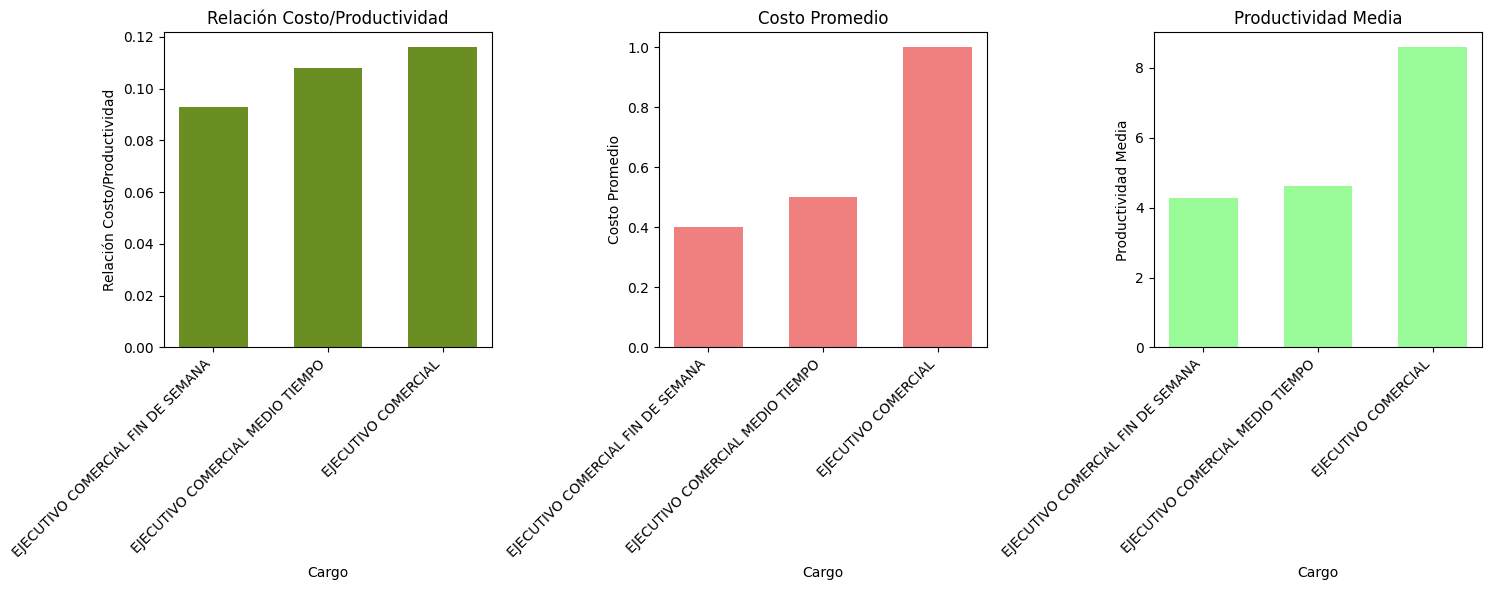

In [7]:
# GRAFICOS DE BARRA
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

ind = np.arange(len(analisis_cargobase))  
width = 0.60  # El ancho de las barras

# 1. GRAFICO relación costo/productividad
axes[0].bar(ind, analisis_cargobase['rela_costo/productividad'], width, color='olivedrab')
axes[0].set_title('Relación Costo/Productividad')
axes[0].set_xlabel('Cargo')
axes[0].set_ylabel('Relación Costo/Productividad')
axes[0].set_xticks(ind)
axes[0].set_xticklabels(analisis_cargobase['cargobase'], rotation=45, ha='right')

# 2.GRAFICO costo promedio
axes[1].bar(ind, analisis_cargobase['costo_promedio'], width, color='lightcoral')
axes[1].set_title('Costo Promedio')
axes[1].set_xlabel('Cargo')
axes[1].set_ylabel('Costo Promedio')
axes[1].set_xticks(ind)
axes[1].set_xticklabels(analisis_cargobase['cargobase'], rotation=45, ha='right')

# 3. GRAFICO productividad media
axes[2].bar(ind, analisis_cargobase['productividad_media'], width, color='palegreen')
axes[2].set_title('Productividad Media')
axes[2].set_xlabel('Cargo')
axes[2].set_ylabel('Productividad Media')
axes[2].set_xticks(ind)
axes[2].set_xticklabels(analisis_cargobase['cargobase'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 2.3 Concluciones

+ La mejor productividad media la tiene el EJECUTIVO COMERCIAL, según el gráfico 'Productividad Media', pero su relación costo/productividad es más alta, lo que lo hace menos eficiente en términos de costo en comparación con el cargo de fin de semana.
+ El mejor costo promedio más bajo lo tiene el cargo EJECUTIVO COMERCIAL FIN DE SEMANA.
+ La mejor relación Costo/Productividad la tiene el cargo EJECUTIVO COMERCIAL FIN DE SEMANA, al ser el menor valor de los tres cargo, significa que el costo es bajo comparto con la productividad del mismo.

Para **incrementar la productividad** la mejor opción es el cargo **EJECUTIVO COMERCIAL FIN DE SEMANA**, ya que es el más eficiente al generar una mayor productividad por unidad de costo.

## Fase 3: Clasificación de los puntos de venta en segmentos

El objetivo es *crear un modelo* por medio de técnicas de aprendizaje no supervisado para *identificar patrones* y *generar estrategias* basadas en los datos utilizando el dataset 'Segmentacion_CATT'

### 3.1 Análisis EDA

Se importan las librerias relacionadas a modelos de Machine Learning, se emplea el modelo K-means clustering para realizar la segmentación de los datos y visualizamos los segmentos identificados para identificar los patrones de los puntos de venta.

#### DataFrame

In [15]:
df_segmentacion

,negocio,region,canal,capturas_tarjetas,aprobacion_tarjetas,tarjetas,capturas_creditos,aprobacion_creditos,cantidad_creditos,monto_creditos,seguros,trafico_transaccional,trafico_clientes,aprovechamiento_de_trafico,contribucion
0,E,ANTIOQUIA,305001,591.25,0.29813,163.00,168.00,0.03384,18.50,53.43834,103.50,125108.25,87108.00,0.00845,2002.20802
1,E,ANTIOQUIA,305002,273.00,0.42289,109.00,36.50,0.01746,4.50,11.53701,75.50,143554.25,89312.75,0.00328,1535.21599
2,E,ANTIOQUIA,305003,1292.00,0.33203,383.50,243.75,0.02835,32.75,95.94125,251.75,256355.00,176842.00,0.00833,2265.08432
3,E,ANTIOQUIA,305004,1411.75,0.21167,269.25,648.75,0.06938,88.25,196.50499,280.75,209293.25,129557.00,0.01561,4278.34350
4,E,BOGOTA 2,305005,550.50,0.25549,122.25,113.00,0.01620,7.75,25.80312,75.50,74420.50,49449.25,0.01366,1552.20988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,A,ALKOSTO,51000001,0.00,NaN,0.00,0.00,NaN,0.00,0.00000,0.00,0.00,0.00,0.00000,0.00000
140,A,ALKOSTO,51000002,0.00,NaN,0.00,0.00,NaN,0.00,0.00000,0.00,0.00,0.00,0.00000,0.00000
141,E,BOGOTA 1,305014,1024.75,0.23361,214.75,312.25,0.03971,36.50,119.04254,214.50,154765.75,94460.50,0.01391,1899.78072
142,E,BOGOTA 1,305015,306.75,0.32983,86.25,52.25,0.01147,3.00,11.08023,50.75,193489.75,130281.25,0.00268,2002.55625


#### Información general del dataset

In [9]:
df_segmentacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   negocio                     144 non-null    object 
 1   region                      144 non-null    object 
 2   canal                       144 non-null    int64  
 3   capturas_tarjetas           144 non-null    float64
 4   aprobacion_tarjetas         141 non-null    float64
 5   tarjetas                    144 non-null    float64
 6   capturas_creditos           144 non-null    float64
 7   aprobacion_creditos         141 non-null    float64
 8   cantidad_creditos           144 non-null    float64
 9   monto_creditos              144 non-null    float64
 10  seguros                     144 non-null    float64
 11  trafico_transaccional       144 non-null    float64
 12  trafico_clientes            144 non-null    float64
 13  aprovechamiento_de_trafico  144 non

Se cuenta con un dataset de 144 filas, 15 campos, de los cuales 12 son de tipo float, 1 tipo entero y 2 tipo string. No se evidencia valores nulos en alguno de los campos.

In [10]:
df_segmentacion.describe()

,canal,capturas_tarjetas,aprobacion_tarjetas,tarjetas,capturas_creditos,aprobacion_creditos,cantidad_creditos,monto_creditos,seguros,trafico_transaccional,trafico_clientes,aprovechamiento_de_trafico,contribucion
count,1.440000e+02,144.000000,141.000000,144.000000,144.000000,141.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,1.419001e+07,553.925347,0.213927,109.684028,112.616319,0.023803,10.135417,27.302725,63.550347,58120.380208,35886.217014,0.010853,919.946729
std,2.231800e+07,562.679015,0.061780,119.865987,119.347516,0.018957,12.767141,33.540927,71.967119,54249.405750,35221.133295,0.010752,1225.155583
min,3.050010e+05,0.000000,0.074470,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-112.543940
25%,3.050368e+05,230.437500,0.179160,39.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,226.736218
50%,3.096305e+05,362.750000,0.208660,70.375000,82.750000,0.025850,5.875000,14.877855,42.625000,54978.875000,32614.625000,0.008675,573.531350
75%,5.000000e+07,629.562500,0.250320,131.625000,169.062500,0.035780,14.750000,38.417217,97.500000,88709.500000,53264.500000,0.016120,1086.874077
max,5.100000e+07,3532.250000,0.422890,735.750000,648.750000,0.084860,88.250000,196.504990,280.750000,256355.000000,176842.000000,0.049110,7650.703390


Verificación de valores nulos

In [17]:
print(df_segmentacion.isnull().sum())

negocio                       0
region                        0
canal                         0
capturas_tarjetas             0
aprobacion_tarjetas           3
tarjetas                      0
capturas_creditos             0
aprobacion_creditos           3
cantidad_creditos             0
monto_creditos                0
seguros                       0
trafico_transaccional         0
trafico_clientes              0
aprovechamiento_de_trafico    0
contribucion                  0
dtype: int64


Se procede a eliminar las celdas con valores nulos, ya que solo representan el 2% del total de 144 filas del dataset

In [19]:
df_segmentacion = df_segmentacion.dropna(subset=['aprobacion_tarjetas', 'aprobacion_creditos'])
df_segmentacion

,negocio,region,canal,capturas_tarjetas,aprobacion_tarjetas,tarjetas,capturas_creditos,aprobacion_creditos,cantidad_creditos,monto_creditos,seguros,trafico_transaccional,trafico_clientes,aprovechamiento_de_trafico,contribucion
0,E,ANTIOQUIA,305001,591.25,0.29813,163.00,168.00,0.03384,18.50,53.43834,103.50,125108.25,87108.00,0.00845,2002.20802
1,E,ANTIOQUIA,305002,273.00,0.42289,109.00,36.50,0.01746,4.50,11.53701,75.50,143554.25,89312.75,0.00328,1535.21599
2,E,ANTIOQUIA,305003,1292.00,0.33203,383.50,243.75,0.02835,32.75,95.94125,251.75,256355.00,176842.00,0.00833,2265.08432
3,E,ANTIOQUIA,305004,1411.75,0.21167,269.25,648.75,0.06938,88.25,196.50499,280.75,209293.25,129557.00,0.01561,4278.34350
4,E,BOGOTA 2,305005,550.50,0.25549,122.25,113.00,0.01620,7.75,25.80312,75.50,74420.50,49449.25,0.01366,1552.20988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,A,ALKOSTO,50000076,2528.00,0.23986,550.25,0.00,0.00000,0.00,0.00000,0.00,0.00,0.00,0.00000,-112.54394
138,A,ALKOSTO,50000077,145.25,0.21965,28.50,0.00,0.00000,0.00,0.00000,0.00,0.00,0.00,0.00000,-73.16321
141,E,BOGOTA 1,305014,1024.75,0.23361,214.75,312.25,0.03971,36.50,119.04254,214.50,154765.75,94460.50,0.01391,1899.78072
142,E,BOGOTA 1,305015,306.75,0.32983,86.25,52.25,0.01147,3.00,11.08023,50.75,193489.75,130281.25,0.00268,2002.55625


#### Distribución de variables numéricas

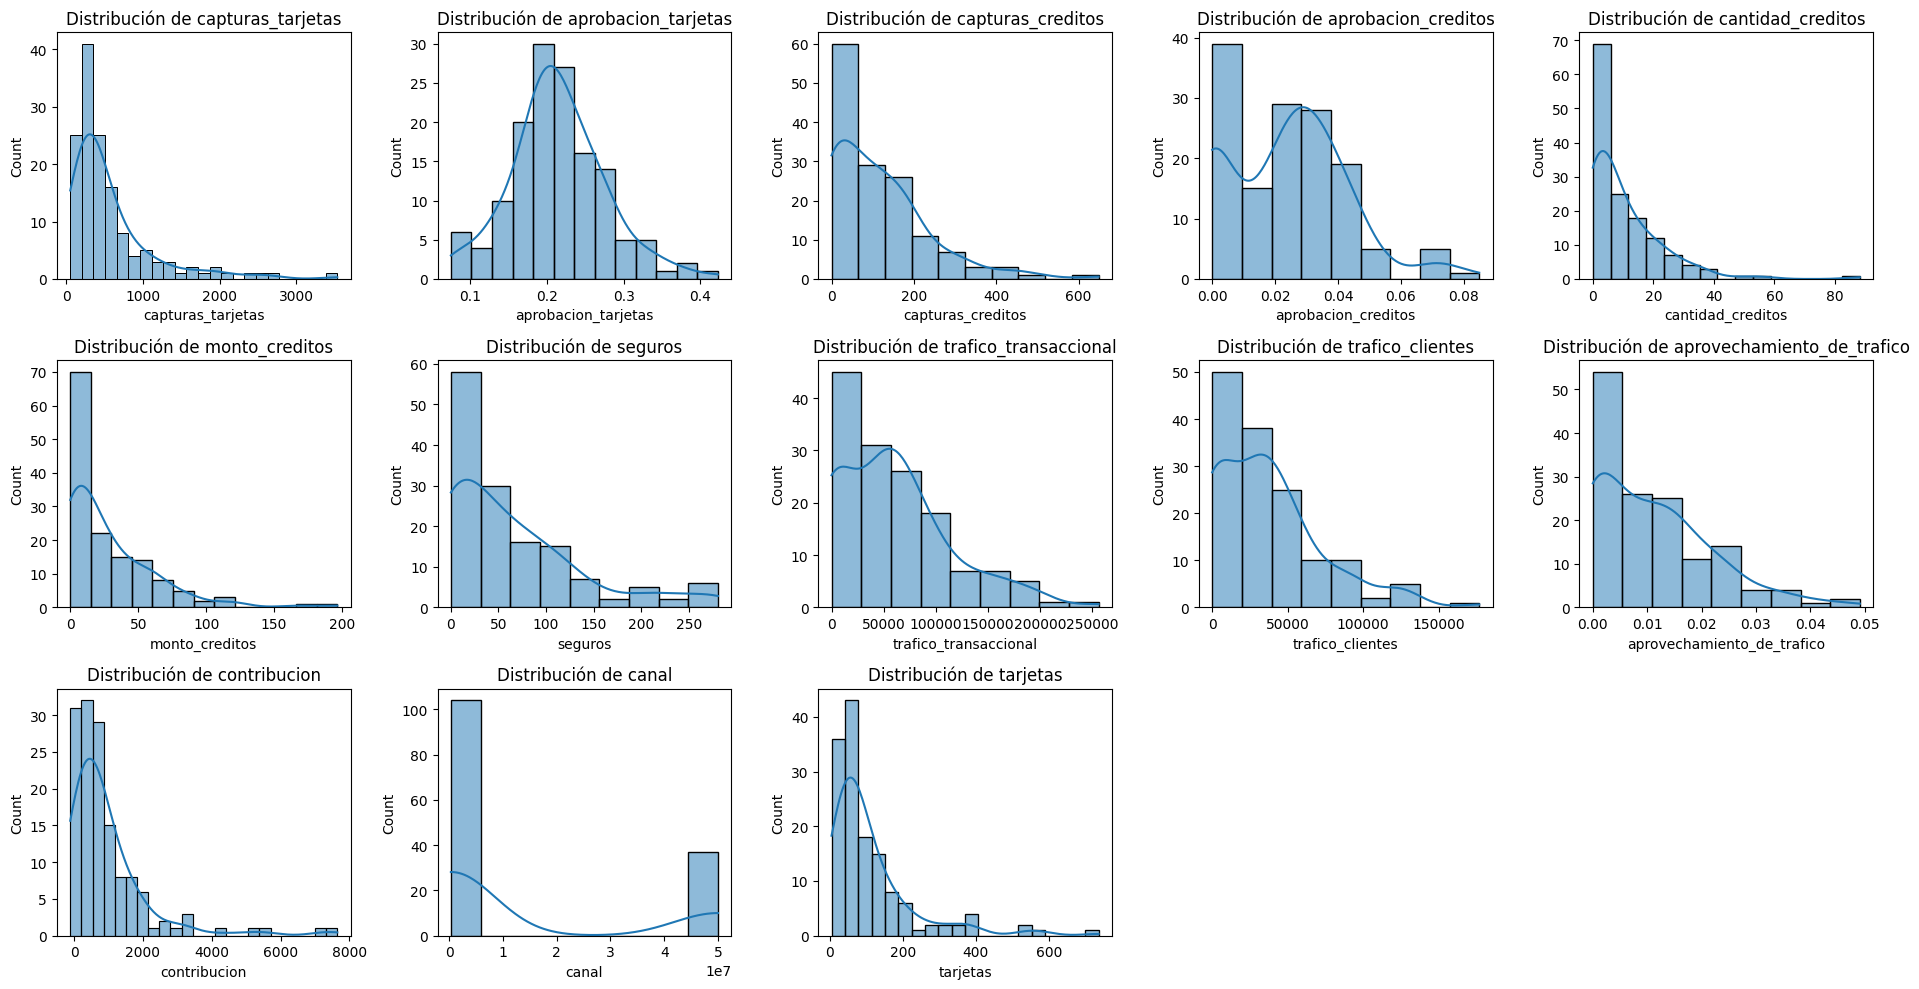

In [20]:
# DISTRIBUCIÓN DE LAS VARIABLES NUMÉRICAS

import seaborn as sns

col_numericas = ['capturas_tarjetas', 'aprobacion_tarjetas', 'capturas_creditos', 
                'aprobacion_creditos', 'cantidad_creditos', 'monto_creditos', 
                'seguros', 'trafico_transaccional', 'trafico_clientes',
                'aprovechamiento_de_trafico', 'contribucion',
                'canal', 'tarjetas']

plt.figure(figsize=( 19, 10))
for i, column in enumerate(col_numericas):
    plt.subplot(3, 5, i + 1)  # 3 filas y 4 columnas de subgráficos
    sns.histplot(df_segmentacion[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.tight_layout()

plt.show()

Se observa que la mayoría de variables numéricas, presentan una distribución con sesgo a la derecha, esto se traduce en que la mayoría de sus valores tienden estar en los rangos más bajo de la escala, y que algunos valores extremos podrían arrastrar la media hacia valores más altos, por tanto, es necesario aplicar una normalización.

#### Correlación entre variables

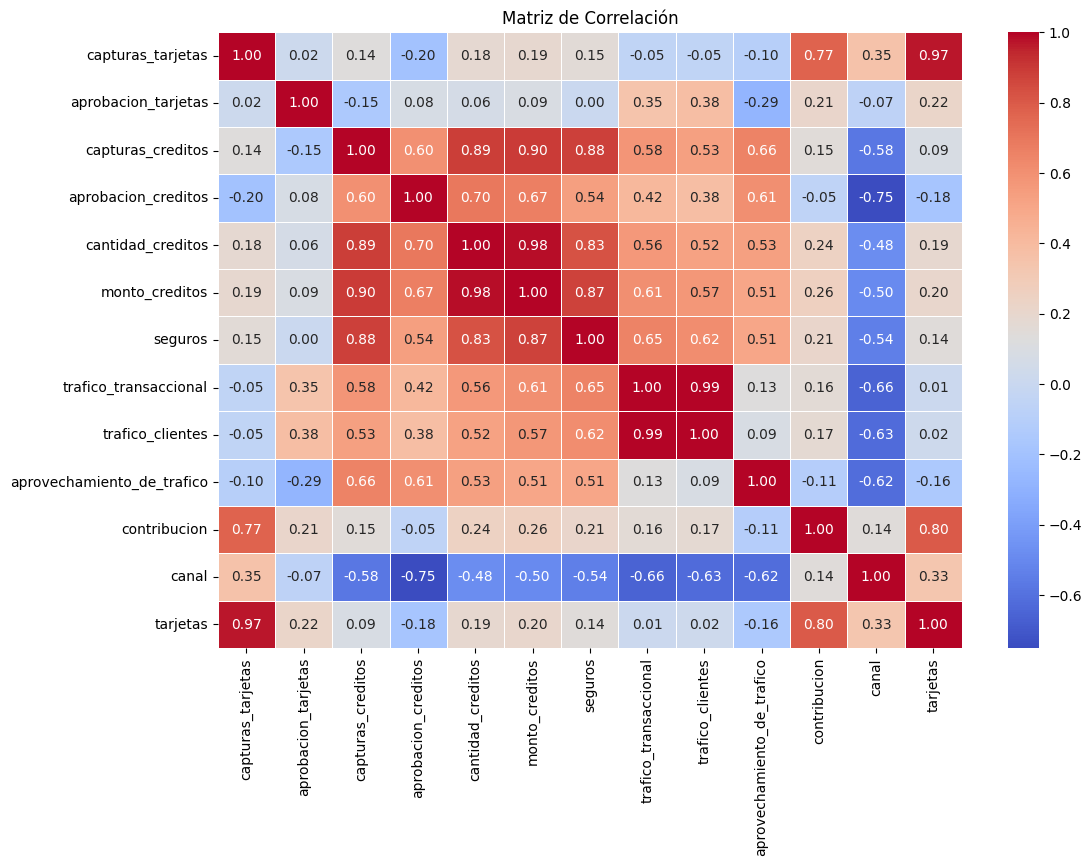

In [21]:
# GRÁFICO DE CORRELACIÓN
corr_matrix = df_segmentacion[col_numericas].corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

Se observa que existe una fuerte correlación entre las variables numéricas, los valores por encima de 0.83 en la escala de correlación significan que podrían haber relaciones interesantes entre ellas.

Las relaciones: capturas_creditos - cantidad_creditos, capturas_creditos - monto_creditos, capturas_creditos - seguros, seguros - cantidad_creditos, trafico_transaccional - trafico_cliente, contribucion - tarjetas, tarjetas - capturas_tarjetas y seguros - monto_creditos, presentan correlaciones por encima del 0.80

### 3.2 K-Means Clustering

In [ ]:
# -- LIBRERIAS PARA CLUSTERING
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# ESCALADO DE VARIABLES NUMÉRICAS
scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_segmentacion[col_numericas])

#### Método del codo

Este método permite encontrar el número óptimo de clusters

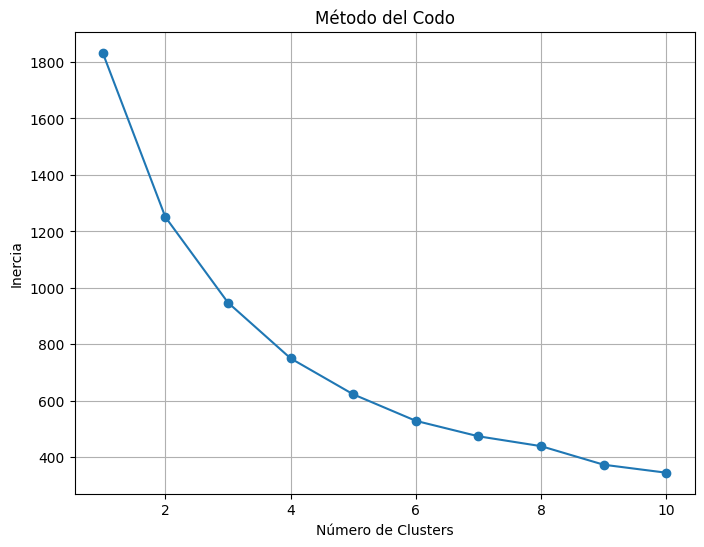

In [ ]:
# GRAFICO DEL MÉTODO DEL CODO

inertia = []
for k in range(1, 11):  # Probar con 1 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_escalado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

La gráfica del codo muestra el *número óptimo de clusters*, el cual es **4**. En ese punto, la curva presenta un cambio notable en la pendiente: antes de 4, la inercia disminuye rápidamente, y después de ese valor, la mejora es mucho más gradual. Esto indica que agregar más clusters no aporta beneficios significativos al modelo.

#### Clusterización

Se escoge 4 números de clusters, esto, en base al análisis del método del codo

In [33]:
# -- CLUSTERING
kmeans = KMeans(n_clusters=4, random_state=42)

# SEGMENTOS
df_segmentacion['Segmento'] = kmeans.fit_predict(df_escalado)

# CANTIDAD DE PUNTOS EN CADA SEGMENTO (CLUSTER)
print(df_segmentacion['Segmento'].value_counts())

Segmento
0    92
3    27
2    12
1    10
Name: count, dtype: int64


**Revisión de cada segmento**

In [54]:
resumen_segmento = df_segmentacion.groupby('Segmento')[col_numericas].describe()
resumen_segmento

capturas_tarjetas                                              \
                     count         mean         std     min        25%   
Segmento                                                                 
0                     92.0   359.975543  179.300066    88.5   233.5000   
1                     10.0  2192.200000  606.259488  1486.5  1873.6250   
2                     12.0  1123.000000  242.090657   832.0   954.8125   
3                     27.0   416.648148  327.056498    54.0   150.7500   

                                      aprobacion_tarjetas            ...  \
               50%       75%      max               count      mean  ...   
Segmento                                                             ...   
0          325.375   416.500   897.75                92.0  0.215087  ...   
1         1987.500  2481.000  3532.25                10.0  0.220048  ...   
2         1057.000  1276.625  1634.75                12.0  0.225748  ...   
3          315.250   581.125  1160.50                27.0  0.202453  ...   

                canal             tarjetas                                  \
                  75%         max    count        mean         std     min   
Segmento                                                                     
0           356831.25    888587.0     92.0   69.497283   41.001348   19.75   
1         50000038.00  50000076.0     10.0  450.400000  143.353012  299.50   
2           305023.50    305068.0     12.0  231.145833   76.673041  141.25   
3         50000047.00  50000077.0     27.0   78.629630   63.059243    5.50   

                                               
               25%      50%       75%     max  
Segmento                                       
0          39.6250   60.125   86.0000  196.50  
1         353.8125  383.000  548.0625  735.75  
2         178.1875  213.000  270.8750  383.50  
3          29.1250   61.000  116.2500  245.75  

[4 rows x 104 columns]

**Análisis de los Segmentos:**
1. Segmento 0:
Cantidad de puntos de venta: 92

*Patrón*: Este segmento muestra altos valores en capturas de tarjetas, aprobación de tarjetas, y monto de créditos. A pesar de las grandes cantidades en estas métricas, la captura de tarjetas y el monto de créditos se encuentran en valores mucho más altos que en otros segmentos.

*Comportamiento*: Este segmento probablemente representa puntos de venta con un alto rendimiento en transacciones, lo que puede ser indicativo de puntos de venta con gran volumen de clientes o ubicaciones con alta demanda.

2. Segmento 1:
Cantidad de puntos de venta: 10

*Patrón*: Este segmento tiene bajos valores en casi todas las métricas. Los valores de capturas de tarjetas y monto de créditos son bastante bajos, lo que sugiere que estos puntos de venta tienen poca actividad o un bajo volumen de clientes.

*Comportamiento*: Este segmento podría representar puntos de venta en crecimiento o con una estrategia de marketing aún no optimizada. La baja aprobación de tarjetas y créditos podría ser una oportunidad de mejora.

3. Segmento 2:
Cantidad de puntos de venta: 12

*Patrón*: Este segmento presenta valores moderados en las métricas de capturas de tarjetas y aprobación de créditos, pero destaca en aprovechamiento del tráfico. Aunque el volumen de tráfico y capturas es bajo, estos puntos de venta logran maximizar el rendimiento con los recursos disponibles.

*Comportamiento*: Los puntos de venta en este segmento podrían estar optimizar los recursos que tienen, pero aún no tienen un volumen de clientes comparable al segmento 0. Es posible que necesiten una estrategia de captación de clientes más agresiva.

4. Segmento 3:
Cantidad de puntos de venta: 27

*Patrón*: Este segmento tiene un alto volumen de tráfico y aprobación de tarjetas pero bajo aprovechamiento del mismo. Las métricas de monto de créditos son moderadas, pero los puntos de venta en este segmento no están maximizando su potencial en términos de aprobación de créditos o aprovechamiento del tráfico.

*Comportamiento*: Estos puntos de venta tienen alto potencial en cuanto a tráfico, pero podrían mejorar su conversión de clientes a créditos o ventas. Se recomienda mejorar la eficiencia del tráfico, maximizando las conversiones.

#### Análisis PCA

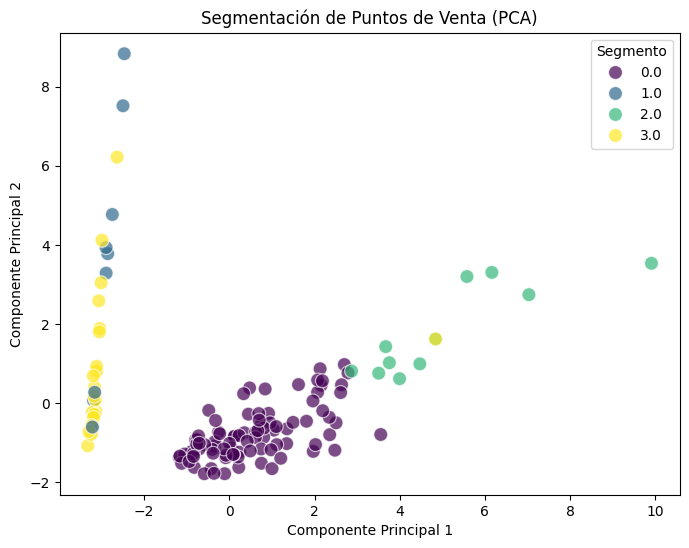

In [50]:
# PCA 2D

from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_escalado)

# DATAFRAME CON LOS COMPONENTES PRINCIPALES Y SEGMENTOS 
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Segmento'] = df_segmentacion['Segmento']

# GRAFICO DE PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Segmento', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Segmentación de Puntos de Venta (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

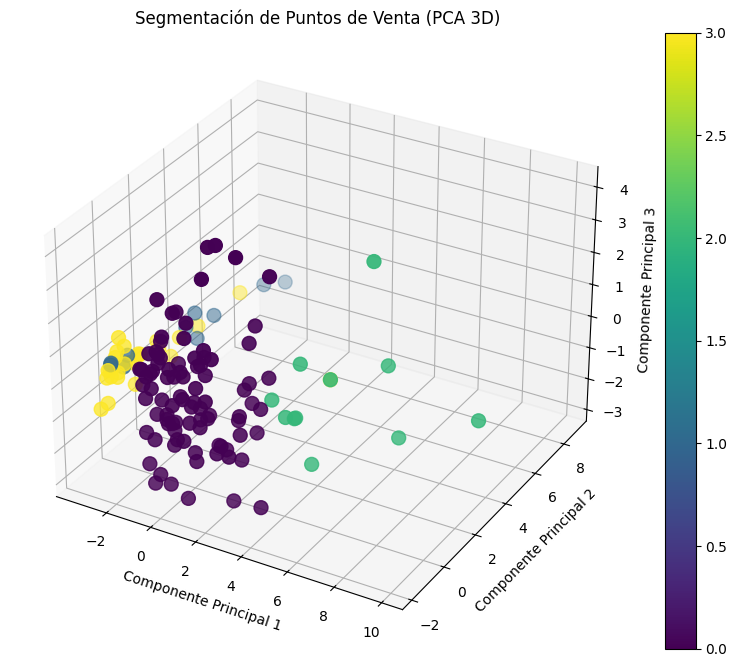

In [ ]:
# PCA 3D
from mpl_toolkits.mplot3d import Axes3D

# Reducir la dimensionalidad a 3 componentes principales
pca = PCA(n_components=3)
pca_components = pca.fit_transform(df_escalado)

# Crear un DataFrame con los componentes principales y los segmentos
pca_df_3d = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df_3d['Segmento'] = df_segmentacion['Segmento']

# Graficar en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_3d['PCA1'], pca_df_3d['PCA2'], pca_df_3d['PCA3'], 
                     c=pca_df_3d['Segmento'], cmap='viridis', s=100)
plt.title('Segmentación de Puntos de Venta (PCA 3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.colorbar(scatter)
plt.show()

Entre los gráficos para análisis PCA, se ve que, inicialmente con el PCA de dos dimensiones, se podría concluir que los segmentos 3 y 1 son similares como 2 y 4, sin embargo, el PCA 3D muestra que cada segmento está bien definido con algunos puntos que comparten similitud

#### Visualización de los segmentos

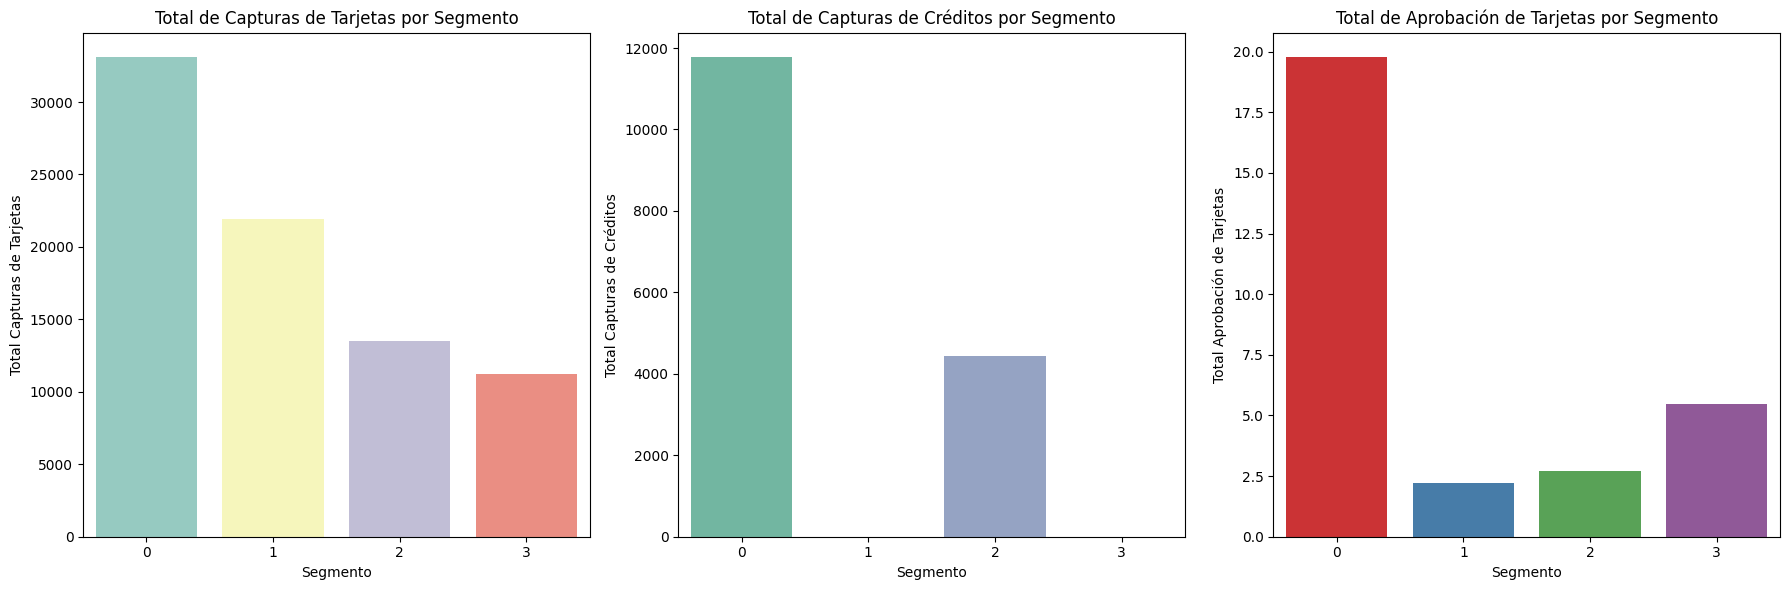

In [78]:
# PLOTS

total_capturas_tarjetas = df_segmentacion.groupby('Segmento')['capturas_tarjetas'].sum().reset_index()
total_capturas_creditos = df_segmentacion.groupby('Segmento')['capturas_creditos'].sum().reset_index()  # Cambié a capturas_creditos
total_aprobacion_tarjetas = df_segmentacion.groupby('Segmento')['aprobacion_tarjetas'].sum().reset_index()

# Crear un gráfico con 3 subgráficos (uno para cada métrica)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila y 3 columnas de subgráficos

# 1. Gráfico para Capturas de Tarjetas (totales por segmento)
sns.barplot(x='Segmento', y='capturas_tarjetas', data=total_capturas_tarjetas, hue='Segmento', palette='Set3', ax=axes[0], legend=False)
axes[0].set_title('Total de Capturas de Tarjetas por Segmento')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Total Capturas de Tarjetas')

# 2. Gráfico para Capturas de Créditos (totales por segmento) - Cambié a capturas_creditos
sns.barplot(x='Segmento', y='capturas_creditos', data=total_capturas_creditos, hue='Segmento', palette='Set2', ax=axes[1], legend=False)
axes[1].set_title('Total de Capturas de Créditos por Segmento')  # Título actualizado
axes[1].set_xlabel('Segmento')
axes[1].set_ylabel('Total Capturas de Créditos')

# 3. Gráfico para Aprobación de Tarjetas (totales por segmento)
sns.barplot(x='Segmento', y='aprobacion_tarjetas', data=total_aprobacion_tarjetas, hue='Segmento', palette='Set1', ax=axes[2], legend=False)
axes[2].set_title('Total de Aprobación de Tarjetas por Segmento')
axes[2].set_xlabel('Segmento')
axes[2].set_ylabel('Total Aprobación de Tarjetas')

# Ajustar el espacio entre los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

### 3.3 Recomendaciones estratégicas

1. Para el Segmento 0 (alto rendimiento):

    - Estrategias de Expansión: Dado que este segmento está bien consolidado con un alto volumen de capturas de tarjetas y aprobación de créditos, se podría aprovechar para expandir su oferta de productos financieros, como préstamos personales o seguros.
    - Fidelización y recompensas: Implementar programas de fidelización para asegurar la retención de clientes y premiar el alto rendimiento.
    - Promociones de créditos: Aumentar las promociones para credibilidad de tarjetas y créditos aprovechando su alta capacidad de aprobación.

2. Para los Segmentos 1 y 3 (bajo rendimiento):

    - Segmento 1: Revisión de estrategias de captación de clientes. Dado que la actividad es baja, es esencial aumentar el tráfico de clientes y mejorar las estrategias de marketing. Se podría considerar la implementación de promociones agresivas o alianzas con empresas para aumentar el volumen de clientes.
    - Segmento 3: Aunque tienen tráfico, no aprovechan el crédito. Mejorar el aprovechamiento del tráfico mediante la introducción de ofertas de crédito más atractivas o incluso capacitaciones al personal para mejorar las conversiones en ventas o créditos.

3. Para el Segmento 2 (optimización):

    - Optimizar la conversión de clientes. Aunque el segmento tiene un bajo volumen de créditos, tienen un buen aprovechamiento de tráfico. Se recomienda mejorar las conversiones y aumentar el número de créditos aprobados. Esto podría lograrse mediante estrategias de marketing dirigidas a clientes específicos con promociones de crédito.

4. Estrategias de colaboración:
    - Alianzas estratégicas: Los segmentos con bajo rendimiento en créditos podrían beneficiarse de alianzas con bancos o instituciones financieras para ofrecer mejores productos de crédito.
    - Capacitación de personal: Mejorar el aprovechamiento de tráfico mediante entrenamientos para los empleados sobre cómo convertir mejor las oportunidades de ventas.

## Fase 4: Presentación de Resultados

### Segmentación y Patrones Clave en los Puntos de Venta

- Segmento 0: Alto rendimiento en capturas y aprobaciones

    Patrón: Este segmento tiene un alto volumen en capturas de tarjetas y aprobaciones de créditos. Se destacan en actividades transaccionales, con valores altos en captura y aprobación de créditos.

- Segmento 1: Bajo rendimiento en capturas y aprobaciones

    Patrón: Este segmento muestra bajos niveles de actividad en las capturas de tarjetas y aprobación de créditos. Los puntos de venta en este segmento tienen poco tráfico o no están aprovechando sus oportunidades de ventas y crédito.

- Segmento 2: Optimización del rendimiento con bajo volumen
    
    Patrón: Aunque el segmento muestra un alto aprovechamiento del tráfico, el volumen de aprobaciones de créditos es bajo. Los puntos de venta logran convertir eficientemente el tráfico de clientes, pero necesitan mejorar las conversiones a créditos.

- Segmento 3: Alto tráfico pero bajo aprovechamiento
    
    Patrón: Este segmento tiene alto volumen de tráfico pero bajo aprovechamiento en términos de créditos. Es probable que estos puntos de venta estén recibiendo muchos clientes, pero no estén maximizando las conversiones de créditos.

### Análisis de las Variables Relevantes

- Segmento 0: EJECUTIVOS COMERCIALES para maximizar captación de tarjetas y créditos en puntos de venta con alto rendimiento.
- Segmento 1: EJECUTIVOS COMERCIALES DE MEDIO TIEMPO para aumentar tráfico y conversión en puntos de venta con bajo rendimiento.
- Segmento 2: EJECUTIVOS COMERCIALES DE MEDIO TIEMPO para mejorar las conversiones de clientes a créditos en puntos de venta con buen aprovechamiento de tráfico.
- Segmento 3: EJECUTIVOS COMERCIALES DE MEDIO TIEMPO para mejorar el aprovechamiento del tráfico y la conversión en puntos de venta con alto tráfico.

### Recomendaciones Estratégicas

1. Segmento 0: Contratar EJECUTIVOS COMERCIALES (Tiempo Completo) para maximizar las aprobaciones de créditos y captación de tarjetas. Expansión de productos financieros como créditos adicionales o seguros.

2. Segmento 1: Contratar EJECUTIVOS COMERCIALES DE MEDIO TIEMPO para incrementar el tráfico y las conversiones a créditos. Mejorar las estrategias de captación mediante promociones específicas.

3. Segmento 2: Contratar EJECUTIVOS COMERCIALES DE MEDIO TIEMPO con foco en la conversión de clientes a créditos. Mejorar la eficiencia de la aprobación de créditos a través de entrenamiento especializado.

4. Segmento 3: Contratar EJECUTIVOS COMERCIALES DE MEDIO TIEMPO para maximizar las conversiones a créditos durante los momentos de alto tráfico. Introducir incentivos de crédito y capacitaciones al personal para mejorar la conversión
